<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_modulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test basic DSP functionalities

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [2]:
from optic.dsp.core import pnorm, signal_power, decimate, resample, lowPassFIR, firFilter, clockSamplingInterp, quantizer, upsample, pulseShape, finddelay
from optic.utils import parameters
from optic.plot import eyediagram, plotPSD, pconst
from optic.comm.modulation import modulateGray
import matplotlib.pyplot as plt
import numpy as np
from numba import njit

In [3]:
%load_ext autoreload
%autoreload 2

## Test rational resample

C:\Users\edson\anaconda3\envs\opticommpy-env\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\edson\anaconda3\envs\opticommpy-env\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 0.1)

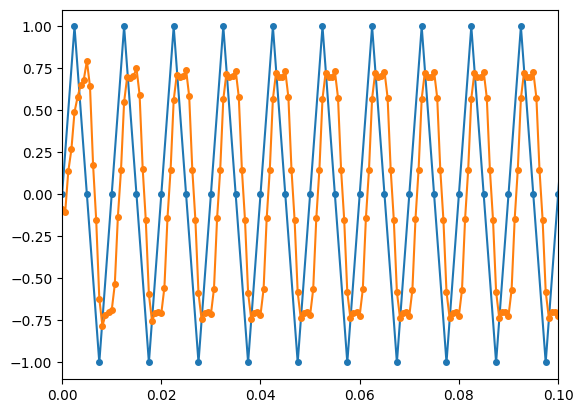

In [4]:
Fs = 400
fc = 100

t = np.arange(0,4096)*(1/Fs)
π = np.pi

sig = np.sin(2*π*fc*t)

plt.plot(t, sig,'-o',markersize=4);
plt.xlim(0, 10*1/fc)

paramDec = parameters()
paramDec.SpS_in = 4
paramDec.SpS_out = 16
paramDec.Rs = fc

resFactor = paramDec.SpS_out/paramDec.SpS_in

t_dec = np.arange(0, int(resFactor*4096))*(1/(resFactor*Fs))
sig_dec = resample(sig, paramDec)

plt.plot(t_dec, sig_dec,'-o',markersize=4);
plt.xlim(0, 10*1/fc)

## Test sampling clock converter

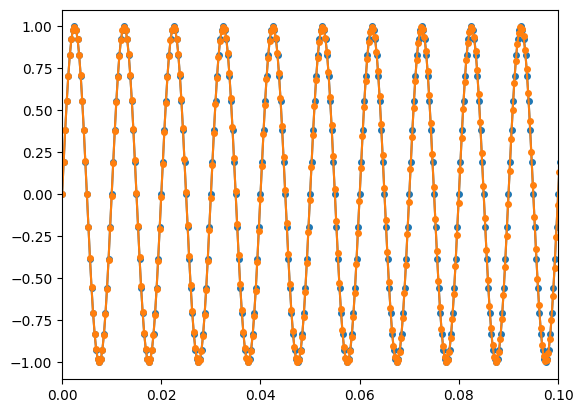

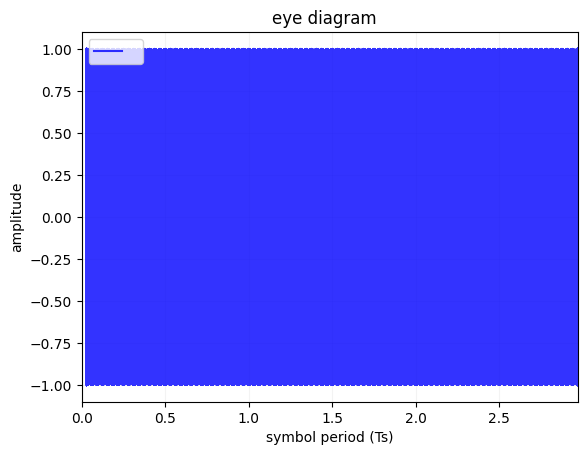

In [5]:
Fs = 3200
fc = 100

t = np.arange(0, 300000)*(1/Fs)
π = np.pi

# generate sinusoidal signal
sig = np.sin(2*π*fc*t)

plt.plot(t, sig,'-o',markersize=4);
plt.xlim(min(t), max(t))

# intermpolate signal to a given clock sampling frequency and jitter
Fs_in = Fs
Fs_out = 1.001*Fs
AAF = False
jitter_rms = 1e-9

t_dec = clockSamplingInterp(t.reshape(-1,1), Fs_in, Fs_out, jitter_rms)
sig_dec = clockSamplingInterp(sig.reshape(-1,1), Fs_in, Fs_out, jitter_rms)
plt.plot(t_dec, sig_dec,'-o',markersize=4);
plt.xlim(0, 10*1/fc)

eyediagram(sig_dec.reshape(-1,), sig_dec.size, int(Fs//fc), n=3, ptype='fast', plotlabel=None)

## Test signal quantizer

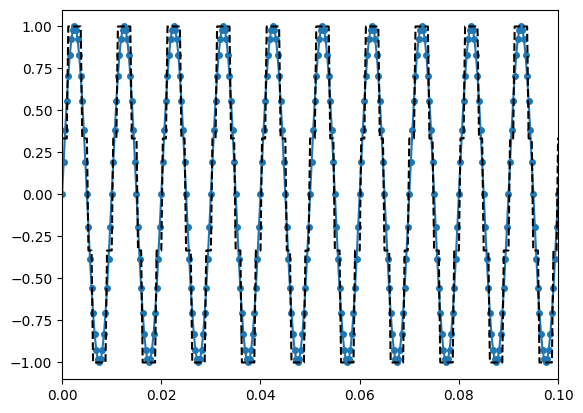

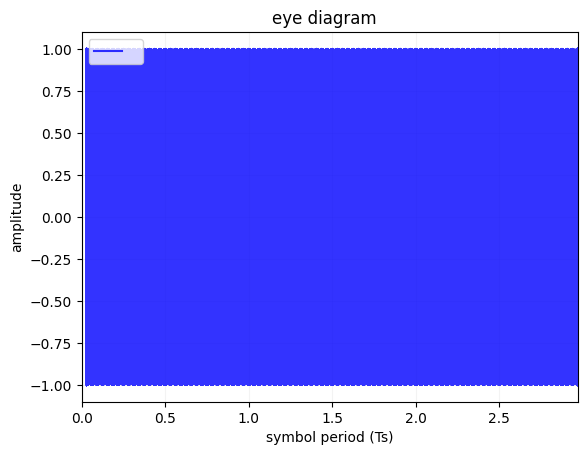

In [6]:
Fs = 3200
fc = 100

t = np.arange(0, 300000)*(1/Fs)
π = np.pi

# generate sinusoidal signal
sig = np.sin(2*π*fc*t) #+ np.sin(6*π*fc*t)/3 + np.sin(10*π*fc*t)/5

plt.plot(t, sig,'-o',markersize=4);
plt.xlim(min(t), max(t))

# quantizer
nBits = 2
sig_q = quantizer(sig.reshape(-1,1), nBits)

plt.plot(t, sig_q,'--k',markersize=4);
plt.xlim(0, 10*1/fc)

eyediagram(sig_dec.reshape(-1,), sig_dec.size, int(Fs//fc), n=3, ptype='fast', plotlabel=None)

In [66]:
def adc(Ei, param):
    """
    Analog-to-digital converter (ADC) model.

    Parameters
    ----------
    Ei : ndarray
        Input signal.
    param : core.parameter
        Resampling parameters:
            param.Fs_in  : sampling frequency of the input signal.
            param.Fs_out : sampling frequency of the output signal.
            param.jitter_rms : root mean square (RMS) value of the jitter in seconds.
            param.nBits : number of bits used for quantization.
            param.Vmax : maximum value for the ADC's full-scale range.
            param.Vmin : minimum value for the ADC's full-scale range.
            param.AAF : flag indicating whether to use anti-aliasing filters (True/False).
            param.N : number of taps of the anti-aliasing filters.

    Returns
    -------
    Eo : ndarray
        Resampled and quantized signal.

    """
    # Check and set default values for input parameters
    param.Fs_in = getattr(param, "Fs_in", 1)
    param.Fs_out = getattr(param, "Fs_out", 1)
    param.jitter_rms = getattr(param, "jitter_rms", 0)
    param.nBits = getattr(param, "nBits", 16)
    param.Vmax = getattr(param, "Vmax", 1)
    param.Vmin = getattr(param, "Vmin", -1)
    param.AAF = getattr(param, "AAF", True)
    param.N   = getattr(param, "N", 202)

    # Extract individual parameters for ease of use
    Fs_in = param.Fs_in
    Fs_out = param.Fs_out
    jitter_rms = param.jitter_rms
    nBits = param.nBits
    Vmax = param.Vmax
    Vmin = param.Vmin
    AAF = param.AAF
    N = param.N

    # Reshape the input signal if needed to handle single-dimensional inputs
    try:
        Ei.shape[1]
    except IndexError:
        Ei = Ei.reshape(len(Ei), 1)

    # Get the number of modes (columns) in the input signal
    nModes = Ei.shape[1]
   
    # Apply anti-aliasing filters if AAF is enabled
    if AAF:
        # Anti-aliasing filters:
        Ntaps = min(Ei.shape[0], N)
        hi = lowPassFIR(param.Fs_out/2, param.Fs_in, Ntaps, typeF="rect")
        ho = lowPassFIR(param.Fs_out/2, param.Fs_out, Ntaps, typeF="rect")

        Ei = firFilter(hi, Ei)

    # Signal interpolation to the ADC's sampling frequency
    Eo = clockSamplingInterp(Ei.reshape(-1,nModes), Fs_in, Fs_out, jitter_rms)

    # Uniform quantization of the signal according to the number of bits of the ADC
    Eo = quantizer(Eo, nBits, Vmax, Vmin)

    # Apply anti-aliasing filters to the output if AAF is enabled
    if AAF:
        Eo = firFilter(ho, Eo)    
    
    return Eo

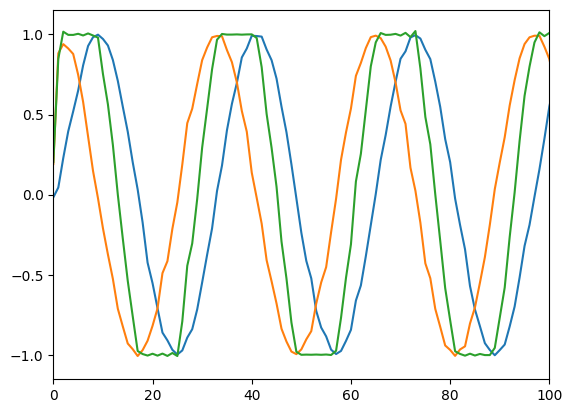

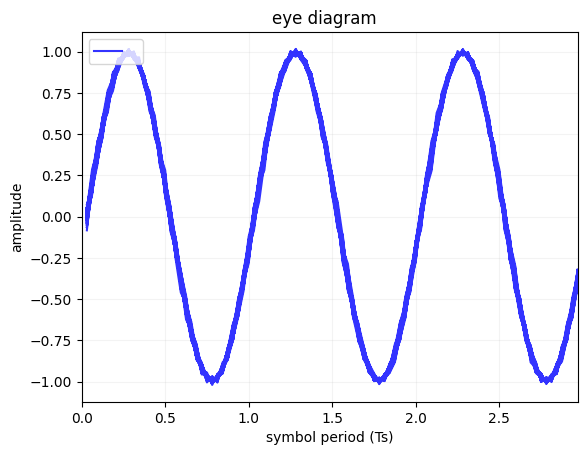

In [8]:
Fs = 3200
fc = 100

t = np.arange(0, 10000)*(1/Fs)
π = np.pi

# generate sinusoidal signal
sig = np.array([np.sin(2*π*fc*t), np.cos(2*π*fc*t), np.sin(2*π*fc*t)+np.cos(2*π*fc*t)]).T

# ADC input parameters
param = parameters()
param.Fs_in = Fs
param.Fs_out = Fs
param.jitter_rms = 5e-5
param.nBits =  16
param.Vmax = 1
param.Vmin = -1
param.AAF = True
param.N = 512

sig_adc = adc(sig, param)

plt.plot(sig_adc)
plt.xlim(0,100);

eyediagram(sig_adc[:,0], sig_adc.shape[0], int(param.Fs_out//fc), n=3, ptype='fast', plotlabel=None)

In [9]:
import numpy as np
from scipy import interpolate

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def gardner_ted_nyquist(x):        
    return np.abs(x[1])**2 * (np.abs(x[0])**2 - np.abs(x[2])**2)

def gardner_ted(x):
    """
    Calculate the timing error using the Gardner timing error detector.

    Parameters
    ----------
    x : numpy.ndarray
        Input array of size 3 representing a segment of the received signal.

    Returns
    -------
    float
        Gardner timing error detector (TED) value.
    """
    return np.real(np.conj(x[1]) * (x[2] - x[0]))


def interpolator(x, t):
    """
    Perform cubic interpolation using the Farrow structure.

    Parameters
    ----------
    x : numpy.ndarray
        Input array of size 4 representing the values for cubic interpolation.
    t : float
        Interpolation parameter.

    Returns
    -------
    y : float
        Interpolated signal value.
    """
    y = x[0] * (-1/6 * t**3 + 1/6 * t) + \
        x[1] * (1/2 * t**3 + 1/2 * t**2 - 1 * t) + \
        x[2] * (-1/2 * t**3 - 1 * t**2 + 1/2 * t + 1) + \
        x[3] * (1/6 * t**3 + 1/2 * t**2 + 1/3 * t)

    return y


def clockRecovery(Ei, param=None):
    """
    Perform clock recovery using Gardner's algorithm with a loop PI filter.

    Parameters
    ----------
    Ei : numpy.ndarray
        Input array representing the received signal.        
    param : core.parameter
        Resampling parameters:
            kp : Proportional gain for the loop filter. Default is 1e-3.
            ki : Integral gain for the loop filter. Default is 1e-4.
            isNyquist: is the pulse shape a Nyquist pulse? Default is True.
            returnTiming: return estimated timing values. Default is False.

    Returns
    -------
    tuple
        Tuple containing the recovered signal (Eo) and the timing values.
    """    
    # Check and set default values for input parameters
    kp = getattr(param, "kp", 1e-3)
    ki = getattr(param, "ki", 1e-6)
    isNyquist = getattr(param, "isNyquist", True)
    returnTiming = getattr(param, "returnTiming", False)
    
    # Initializing variables:
    intPart = 0
    t_nco = 0

    L = Ei.shape[0]
    Eo = Ei.copy()

    ted = 0
    loopFilterOut = 0
    timing_values = []

    n = 2
    m = 2

    while n < L-1 and m < L-2:
        Eo[n] = interpolator(Ei[m-2:m+2], t_nco)

        if n % 2 == 0:
            if isNyquist:
                ted = gardner_ted_nyquist(Eo[n-2:n+1])
            else:
                ted = gardner_ted(Eo[n-2:n+1])
            
            # Loop PI Filter:
            intPart = ki * ted + intPart
            propPart = kp * ted
            loopFilterOut = propPart + intPart

            t_nco -= loopFilterOut

        n += 1
        m += 1

        # NCO
        if t_nco > 0:
            t_nco -= 1
            m -= 1
        elif t_nco < -1:
            t_nco += 1
            m += 1

        timing_values.append(t_nco)
        
    if returnTiming:
        return Eo, timing_values
    else:
        return Eo

ΔFs = 56.25 ppm


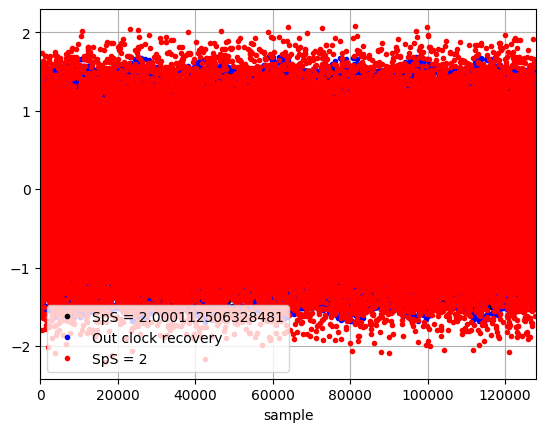

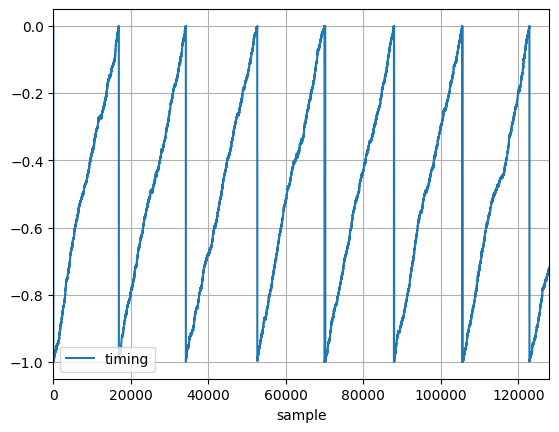

In [86]:
# simulation parameters
SpS = 16          # samples per symbol
M = 16            # order of the modulation format
Rs = 32e9         # Symbol rate (for OOK case Rs = Rb)
Fs = SpS*Rs       # Sampling frequency in samples/second
Ts = 1/Fs         # Sampling period

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size=int(np.log2(M)*64e3))

# generate ook modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'qam')    
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)

# typical NRZ pulse
pulse = pulseShape('rc', SpS, alpha=0.01)
pulse = pulse/max(abs(pulse))

# pulse shaping
sigTx = firFilter(pulse, symbolsUp)

downSample = 7.99955

ΔFs = (Fs/downSample-Fs/8)/(Fs/8)*1e6

print(f'ΔFs = {ΔFs:.2f} ppm')

#sigRx = clockSamplingInterp(sigTx.reshape(-1,1), Fs, Fs/downSample, 1e-12)
sigRxRef = clockSamplingInterp(sigTx.reshape(-1,1), Fs, Fs/8, 0)

# ADC input parameters
paramADC = parameters()
paramADC.Fs_in = Fs
paramADC.Fs_out = Fs/downSample
paramADC.jitter_rms = 0.1e-12
paramADC.nBits =  8
paramADC.Vmax = 1.5
paramADC.Vmin = -1.5
paramADC.AAF = True
paramADC.N = 201

sigRx = adc(sigTx.real, paramADC) + 1j*adc(sigTx.imag, paramADC)

paramCLKREC = parameters()
paramCLKREC.returnTiming = True
paramCLKREC.ki = 1e-6
outCLK, ted_values = clockRecovery(sigRx.reshape(-1,), paramCLKREC)

plt.plot(sigRx,'k.', label=f'SpS = {SpS/downSample}')
plt.plot(outCLK,'b.', label= 'Out clock recovery')
plt.plot(sigRxRef,'r.', label='SpS = 2')
plt.xlabel('sample')
plt.grid()
plt.xlim([0, len(sigRx)])
plt.legend()

plt.figure()
plt.plot( ted_values, label = 'timing')
plt.xlabel('sample')
plt.grid()
plt.xlim([0, len(sigRx)])
plt.legend()

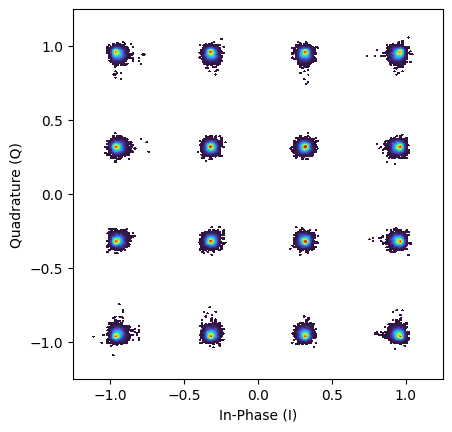

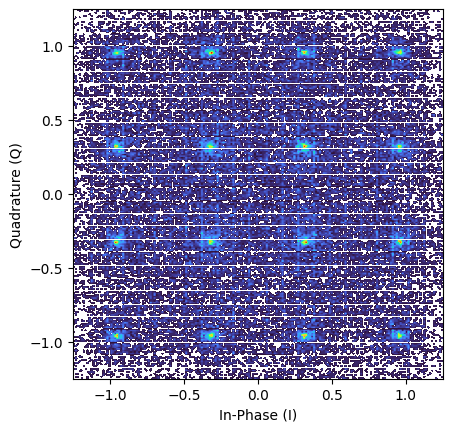

In [87]:
pconst(outCLK[2000:-2:2],pType='fancy');
pconst(sigRx[2000:-2:2], pType='fancy');

In [ ]:
#plt.plot(sigRx[10000:10050],'kx', label=f'SpS = {SpS/downSample}')
plt.plot(outCLK[20000:20200:2],'bo', label= 'Out clock recovery')
plt.plot(np.roll(sigRxRef,4)[20000:20200:2],'r.', label='SpS = 2')
plt.xlabel('sample')
plt.grid()
#plt.xlim([0, len(sigRx[0:50])])
plt.legend()

In [ ]:
finddelay(outCLK[::2], sigRxRef[::2].reshape(-1,))